In [17]:
import sys
import os
# Add the project root to sys.path
sys.path.append(os.path.abspath('..'))

from Functions.gradientdescent_lib import *
from Functions.PLOT import plot
from Functions.bootstrap import *

In [18]:
#generate standard dataset

np.random.seed(1)
x_train, x_test, y_train, y_test = generateData(100, noise = 0.1)
x_train = x_train.flatten(); x_test = x_test.flatten()

Comparison of samplesize 20 with samplesize 80 (whole dataset)

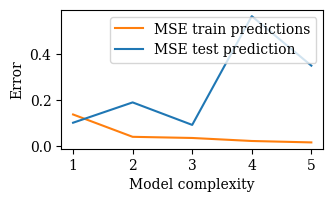

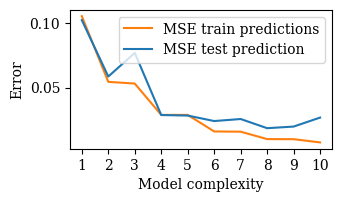

In [ ]:

samplesizes = [20, 80]
n_degrees = [5, 10]

MSEs_train = []
MSEs_test = []

noIntercept = False

for i in range(2):
    samplesize = samplesizes[i]
    poly_degrees = list(range(1, n_degrees[i]+1))

    #pick out dataset
    indices = np.random.randint(0, len(x_train), size = samplesize)
    x_sample = x_train[indices]
    y_sample = y_train[indices]

    MSEs_train = np.zeros(len(poly_degrees), dtype=float)
    MSEs_test = np.zeros(len(poly_degrees), dtype=float)
    
    for p in poly_degrees:
        X_sample = featureMat(x_sample, p, noIntercept=noIntercept)
        X_test = featureMat(x_test, p, noIntercept=noIntercept)

        theta = theta_analytic_OLS(X_sample, y_sample)
        y_sample_pred = X_sample @ theta
        y_test_pred = X_test @ theta

        MSE_train = MSE(y_sample, y_sample_pred)
        MSE_test = MSE(y_test, y_test_pred)

        MSEs_train[p-1] = MSE_train
        MSEs_test[p-1] = MSE_test
    

    plot(
        nGraphs = 2,
        x_axis_array = poly_degrees,
        y_features = [MSEs_train, MSEs_test],
        y_feature_label = ['MSE train predictions', 'MSE test prediction'],
        foldername = 'figures',
        figurename = f'polynomial_fit_with{samplesize}',
        x_label = 'Model complexity',
        y_label = 'Error',
        title = '',
        x_integer_entries = True,
        y_integer_entries = False,
        save = True,
        scatter = None,
        multiX = False
    )